<div style="text-align: center; font-size: 40px; font-weight: bold;">
    PAYLATER RISK PREDICTION
   
</div>

<div style="text-align: center; font-size: 24px;">
    Author: Marta Afifah
</div>



<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Background 
   
</div>

**PDM Paylater** adalah perusahaan fiktif penyedia layanan Buy Now Pay Later (BNPL) yang utamanya mendapatkan pendapatan dengan memberikan pinjaman uang. Salah satu risiko utama dalam praktik ini adalah kemungkinan peminjam gagal membayar pinjamannya, dengan menghentikan pembayaran sesuai kesepakatan. Hal ini akan menyebabkan kerugian keuangan bagi perusahaan.

Untuk mengurangi kerugian tersebut, sangat penting bagi PDM Paylater untuk membuat keputusan yang terinformasi (berbasiskan data) tentang kepada siapa memberikan pinjaman. Pada dasarnya, mereka perlu menilai risiko yang terkait dengan setiap peminjam dan membuat keputusan pemberian pinjaman berdasarkan hal itu.

<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Dataset Information
</div>

- `variabel_description.csv`: metadata
- `train.csv`: Dataset utama yang digunakan dalam pembentukan model klasifikasi, berisi informasi setiap aktivitas pengajuan pinjaman (aplikasi) oleh seorang calon peminjam. Label target yang digunakan adalah `FLAG`, menunjukan apakah seorang calon peminjam akan diberikan pinjaman (`1`) atau tidak (`0`). Hal ini didasarkan pada prediksi apakah seorang calon peminjam akan sanggup dalam memenuhi kewajibannya melunasi pinjaman dengan tepat waktu atau tidak.
- `test.csv`: Digunakan dalam uji performa (evaluasi) model terbaik yang dibentuk menggunakan dataset train.csv. Berisi informasi setiap aktivitas pengajuan pinjaman oleh seorang calon peminjam. Label target yang digunakan adalah `FLAG`.
- `previous_application.csv`: Berisi informasi tentang data pengajuan pinjaman (aplikasi) sebelumnya. Terhubung dengan data train.csv dan test.csv berdasarkan fitur `U_ID`.
- `payment_history.csv`: Data pembayaran yang lalu untuk setiap pinjaman sebelumnya. Terhubung dengan data train.csv dan test.csv berdasarkan fitur `U_ID`, serta terhubung dengan data previous_application.csv berdasarkan fitur `SK_ID_PREV`.

<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Target Perusahaan
</div>

- Menyetujui pinjaman dari calon peminjam yang diprediksi memiliki risiko gagal bayar rendah.
- Menolak pengajuan pinjaman dari calon peminjam yang diprediksi memiliki risiko gagal bayar tinggi.

<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Tujuan
</div>

- Memprediksi calon peminjam mana yang layak mendapatkan pinjaman.
- Mengidentifikasi hal-hal yang membedakan peminjam yang baik atau buruk.

<a name="0"></a>
# **0 - Import Data & Library**
### Library

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

### Dataset

In [72]:
df_tr = pd.read_csv("C:/Users/Lenovo/OneDrive/PORTOFOLIO/Paylater Risk Prediction/Dataset/train.csv") # data train
df_te = pd.read_csv("C:/Users/Lenovo/OneDrive/PORTOFOLIO/Paylater Risk Prediction/Dataset/test.csv") # data test
df_pre = pd.read_csv("C:/Users/Lenovo/OneDrive/PORTOFOLIO/Paylater Risk Prediction/Dataset/previous_applications.csv") # data previous application
df_his = pd.read_csv("C:/Users/Lenovo/OneDrive/PORTOFOLIO/Paylater Risk Prediction/Dataset/payment_history.csv") # data payment history

In [73]:
display(df_tr.head(), df_te.head())

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,...,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,...,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,...,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,...,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,...,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595


,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
0,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,Working,...,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,NaN,0.145475,0.651260
1,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,Working,...,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,NaN,0.682675,NaN
2,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,Working,...,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393
3,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,Working,...,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.399219,0.266520,0.058826
4,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,Working,...,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.368452,0.610483,0.392774


In [74]:
display(df_pre.head(), df_his.head())

,SK_ID_PREV,U_ID,CONTRACT_TYPE,LOAN_ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRODUCT_PRICE,APPLY_DAYS,APPLY_HOUR,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Canceled,-14,NaN,NA1,NaN,NaN,NaN,NaN
4,1715995,447712,Cash loans,11368.620,270000.0,335754.0,NaN,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0


,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375
1,2723183,112102,14,-197.0,-197.0,70.740,70.740
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000


<a name="1"></a>
# **1 - Preprocessing Data (1)**
Dilakukan data cleaning dengan tujuan memperbaiki atau menghapus kesalahan, ketidakkonsistenan, dan ketidakakuratan dalam kumpulan data. Identifikasi hal ini dilakukan pada dataset train.csv dan test.csv serta dilakukan secara general berdasarkan eksplorasi awal.

Pertama, akan dilihat struktur dari data train dan data test terlebih dahulu

In [75]:
display(df_tr.info(), df_te.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   61503 non-null  int64  
 1   FLAG                   61503 non-null  int64  
 2   CONTRACT_TYPE          61503 non-null  object 
 3   GENDER                 61503 non-null  object 
 4   NUM_OF_CHILDREN        61503 non-null  int64  
 5   INCOME                 61503 non-null  float64
 6   APPROVED_CREDIT        61503 non-null  float64
 7   LOAN_ANNUITY           61502 non-null  float64
 8   PRODUCT_PRICE          61441 non-null  float64
 9   INCOME_CATEGORY        61503 non-null  object 
 10  EDUCATION              61503 non-null  object 
 11  FAMILY_STATUS          61503 non-null  object 
 12  HOUSING_CATEGORY       61503 non-null  object 
 13  DAYS_AGE               61503 non-null  int64  
 14  DAYS_WORK              61503 non-null  int64  
 15  DA

None

None

Selanjutnya, akan dicek apakah terdapat duplikasi pada data

In [76]:
df_tr.duplicated().any()

False

In [77]:
df_te.duplicated().any()

False

Tidak terdapat duplikasi data pada data train ataupun data test.

Sleanjutnya, akan dicek unique values dari tiap variabel kategorik:

In [78]:
for column in df_tr.select_dtypes(include='object').columns:
    print(f"Nilai unik untuk kolom data train'{column}': {df_tr[column].unique()}")

Nilai unik untuk kolom data train'CONTRACT_TYPE': ['Revolving loans' 'Cash loans']
Nilai unik untuk kolom data train'GENDER': ['F' 'M']
Nilai unik untuk kolom data train'INCOME_CATEGORY': ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Unemployed'
 'Student' 'Businessman']
Nilai unik untuk kolom data train'EDUCATION': ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Nilai unik untuk kolom data train'FAMILY_STATUS': ['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
Nilai unik untuk kolom data train'HOUSING_CATEGORY': ['With parents' 'House / apartment' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']
Nilai unik untuk kolom data train'APPLY_DAYS': ['TUESDAY' 'THURSDAY' 'WEDNESDAY' 'SUNDAY' 'MONDAY' 'FRIDAY' 'SATURDAY']
Nilai unik untuk kolom data train'ORGANIZATION_CATEGORY': ['Business Entity Type 3' 'Other' 'NA1' 'Culture' 'Construction'
 'Self-employed' 'Uni

In [79]:
for column in df_te.select_dtypes(include='object').columns:
    print(f"Nilai unik untuk kolom data train'{column}': {df_te[column].unique()}")

Nilai unik untuk kolom data train'CONTRACT_TYPE': ['Cash loans' 'Revolving loans']
Nilai unik untuk kolom data train'GENDER': ['M' 'F']
Nilai unik untuk kolom data train'INCOME_CATEGORY': ['Working' 'Pensioner' 'Commercial associate' 'State servant' 'Unemployed']
Nilai unik untuk kolom data train'EDUCATION': ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Nilai unik untuk kolom data train'FAMILY_STATUS': ['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
Nilai unik untuk kolom data train'HOUSING_CATEGORY': ['House / apartment' 'Office apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Co-op apartment']
Nilai unik untuk kolom data train'APPLY_DAYS': ['SATURDAY' 'MONDAY' 'THURSDAY' 'TUESDAY' 'FRIDAY' 'WEDNESDAY' 'SUNDAY']
Nilai unik untuk kolom data train'ORGANIZATION_CATEGORY': ['Business Entity Type 3' 'Kindergarten' 'Self-employed' 'Other'
 'Security' 'Business Entity Type 2' 'NA1' 'Tr

Baik pada data train maupun data test, terdapat data berisi "NA1" yang seharusnya adalah missing value. Oleha karena itu, nilai tersebut akan diubah menjadi missing:

In [80]:
df_tr.replace("NA1", np.nan, inplace=True)
df_te.replace("NA1", np.nan, inplace=True)

In [81]:
for column in df_tr.select_dtypes(include='object').columns:
    print(f"Nilai unik untuk kolom data train'{column}': {df_tr[column].unique()}")

Nilai unik untuk kolom data train'CONTRACT_TYPE': ['Revolving loans' 'Cash loans']
Nilai unik untuk kolom data train'GENDER': ['F' 'M']
Nilai unik untuk kolom data train'INCOME_CATEGORY': ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Unemployed'
 'Student' 'Businessman']
Nilai unik untuk kolom data train'EDUCATION': ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Nilai unik untuk kolom data train'FAMILY_STATUS': ['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
Nilai unik untuk kolom data train'HOUSING_CATEGORY': ['With parents' 'House / apartment' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']
Nilai unik untuk kolom data train'APPLY_DAYS': ['TUESDAY' 'THURSDAY' 'WEDNESDAY' 'SUNDAY' 'MONDAY' 'FRIDAY' 'SATURDAY']
Nilai unik untuk kolom data train'ORGANIZATION_CATEGORY': ['Business Entity Type 3' 'Other' nan 'Culture' 'Construction'
 'Self-employed' 'Unive

In [82]:
for column in df_te.select_dtypes(include='object').columns:
    print(f"Nilai unik untuk kolom data train'{column}': {df_te[column].unique()}")

Nilai unik untuk kolom data train'CONTRACT_TYPE': ['Cash loans' 'Revolving loans']
Nilai unik untuk kolom data train'GENDER': ['M' 'F']
Nilai unik untuk kolom data train'INCOME_CATEGORY': ['Working' 'Pensioner' 'Commercial associate' 'State servant' 'Unemployed']
Nilai unik untuk kolom data train'EDUCATION': ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Nilai unik untuk kolom data train'FAMILY_STATUS': ['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
Nilai unik untuk kolom data train'HOUSING_CATEGORY': ['House / apartment' 'Office apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Co-op apartment']
Nilai unik untuk kolom data train'APPLY_DAYS': ['SATURDAY' 'MONDAY' 'THURSDAY' 'TUESDAY' 'FRIDAY' 'WEDNESDAY' 'SUNDAY']
Nilai unik untuk kolom data train'ORGANIZATION_CATEGORY': ['Business Entity Type 3' 'Kindergarten' 'Self-employed' 'Other'
 'Security' 'Business Entity Type 2' nan 'Trad

Penulisan missing value sudah sesuai yang diinginkan.

Selanjutnya, akan dilakukan pengisisan missing value pada variabel ORGANIZATION_CATEGORY dengan modus

In [83]:
df_tr['ORGANIZATION_CATEGORY'].fillna(value = df_tr['ORGANIZATION_CATEGORY'].mode()[0], inplace = True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\855563917.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tr['ORGANIZATION_CATEGORY'].fillna(value = df_tr['ORGANIZATION_CATEGORY'].mode()[0], inplace = True)


In [84]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   61503 non-null  int64  
 1   FLAG                   61503 non-null  int64  
 2   CONTRACT_TYPE          61503 non-null  object 
 3   GENDER                 61503 non-null  object 
 4   NUM_OF_CHILDREN        61503 non-null  int64  
 5   INCOME                 61503 non-null  float64
 6   APPROVED_CREDIT        61503 non-null  float64
 7   LOAN_ANNUITY           61502 non-null  float64
 8   PRODUCT_PRICE          61441 non-null  float64
 9   INCOME_CATEGORY        61503 non-null  object 
 10  EDUCATION              61503 non-null  object 
 11  FAMILY_STATUS          61503 non-null  object 
 12  HOUSING_CATEGORY       61503 non-null  object 
 13  DAYS_AGE               61503 non-null  int64  
 14  DAYS_WORK              61503 non-null  int64  
 15  DA

Missing value pada organization category sudah tertangani.

Selanjutnya, akan dilihat statistik deskriptif dari data train dan data test yang bertipe numerik.

In [85]:
for column in df_tr.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Statistik Deskriptif dari '{column}':\n{df_tr[column].describe()}\n")

Statistik Deskriptif dari 'U_ID':
count     61503.000000
mean     278151.136416
std      102918.206671
min      100009.000000
25%      188767.000000
50%      278357.000000
75%      367424.500000
max      456255.000000
Name: U_ID, dtype: float64

Statistik Deskriptif dari 'FLAG':
count    61503.000000
mean         0.080793
std          0.272519
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG, dtype: float64

Statistik Deskriptif dari 'NUM_OF_CHILDREN':
count    61503.000000
mean         0.411850
std          0.716686
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: NUM_OF_CHILDREN, dtype: float64

Statistik Deskriptif dari 'INCOME':
count    6.150300e+04
mean     1.690789e+05
std      1.339697e+05
min      2.610000e+04
25%      1.125000e+05
50%      1.485000e+05
75%      2.025000e+05
max      1.800009e+07
Name: INCOME, dtype: float64

Statistik Desk

In [86]:
for column in df_te.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Statistik Deskriptif dari '{column}':\n{df_te[column].describe()}\n")

Statistik Deskriptif dari 'U_ID':
count     14761.000000
mean     278759.502879
std      102112.465678
min      100054.000000
25%      190910.000000
50%      278940.000000
75%      366655.000000
max      456249.000000
Name: U_ID, dtype: float64

Statistik Deskriptif dari 'FLAG':
count    14761.000000
mean         0.081499
std          0.273608
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG, dtype: float64

Statistik Deskriptif dari 'NUM_OF_CHILDREN':
count    14761.000000
mean         0.411828
std          0.709092
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: NUM_OF_CHILDREN, dtype: float64

Statistik Deskriptif dari 'INCOME':
count    1.476100e+04
mean     1.674965e+05
std      9.538766e+04
min      2.655000e+04
25%      1.125000e+05
50%      1.440000e+05
75%      2.025000e+05
max      2.930026e+06
Name: INCOME, dtype: float64

Statistik Desk

Pada data train ataupun data tes, variabel DAYS_AGE, DAYS_WORK, DAYS_REGISTRATION, DAYS_SINCE_ID_CHANGE bernilai negatif, hal ini tidak mungkin terjadi. Oleh karena itu, variabel tersebut akan diubah ke dalam bentuk positif (karena kemungkinan disebabkan oleh kesalahan penulisan).

In [87]:
kolom = ['DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_SINCE_ID_CHANGE']
for i in kolom:
    df_tr[i] = df_tr[i].abs()
    df_te[i] = df_te[i].abs()

Akan dicek kembali statistik deskriptif dari data yang sudah diperbaiki

In [88]:
for column in df_tr.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Statistik Deskriptif dari '{column}':\n{df_tr[column].describe()}\n")

Statistik Deskriptif dari 'U_ID':
count     61503.000000
mean     278151.136416
std      102918.206671
min      100009.000000
25%      188767.000000
50%      278357.000000
75%      367424.500000
max      456255.000000
Name: U_ID, dtype: float64

Statistik Deskriptif dari 'FLAG':
count    61503.000000
mean         0.080793
std          0.272519
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG, dtype: float64

Statistik Deskriptif dari 'NUM_OF_CHILDREN':
count    61503.000000
mean         0.411850
std          0.716686
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: NUM_OF_CHILDREN, dtype: float64

Statistik Deskriptif dari 'INCOME':
count    6.150300e+04
mean     1.690789e+05
std      1.339697e+05
min      2.610000e+04
25%      1.125000e+05
50%      1.485000e+05
75%      2.025000e+05
max      1.800009e+07
Name: INCOME, dtype: float64

Statistik Desk

Statistik Deskriptif dari 'DAYS_WORK':
count     61503.000000
mean      68772.338764
std      140313.755176
min           3.000000
25%         940.000000
50%        2226.000000
75%        5793.500000
max      365243.000000
Name: DAYS_WORK, dtype: float64

Statistik Deskriptif dari 'DAYS_REGISTRATION':
count    61503.000000
mean      4976.696324
std       3520.926325
min          0.000000
25%       1996.000000
50%       4498.000000
75%       7479.000000
max      22928.000000
Name: DAYS_REGISTRATION, dtype: float64

Statistik Deskriptif dari 'DAYS_SINCE_ID_CHANGE':
count    61503.000000
mean      2996.374681
std       1512.409598
min          0.000000
25%       1713.000000
50%       3263.000000
75%       4304.000000
max       6274.000000
Name: DAYS_SINCE_ID_CHANGE, dtype: float64

Statistik Deskriptif dari 'APPLY_HOUR':
count    61503.000000
mean        12.055136
std          3.273323
min          0.000000
25%         10.000000
50%         12.000000
75%         14.000000
max         23.0

In [89]:
for column in df_te.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Statistik Deskriptif dari '{column}':\n{df_te[column].describe()}\n")

Statistik Deskriptif dari 'U_ID':
count     14761.000000
mean     278759.502879
std      102112.465678
min      100054.000000
25%      190910.000000
50%      278940.000000
75%      366655.000000
max      456249.000000
Name: U_ID, dtype: float64

Statistik Deskriptif dari 'FLAG':
count    14761.000000
mean         0.081499
std          0.273608
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG, dtype: float64

Statistik Deskriptif dari 'NUM_OF_CHILDREN':
count    14761.000000
mean         0.411828
std          0.709092
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: NUM_OF_CHILDREN, dtype: float64

Statistik Deskriptif dari 'INCOME':
count    1.476100e+04
mean     1.674965e+05
std      9.538766e+04
min      2.655000e+04
25%      1.125000e+05
50%      1.440000e+05
75%      2.025000e+05
max      2.930026e+06
Name: INCOME, dtype: float64

Statistik Desk

<a name="2"></a>
# **2 - Exploratory Data Analysis (EDA)**
Tahapan ini dilakukan untuk mendapatkan insight yang bermanfaat dari data.

#### **2.1 - Bagaimana sebaran proporsi pada label target (`FLAG`)?**


Akan dilihat terlebih dahulu jumlah dari label target

In [90]:
df_tr['FLAG'].value_counts()

FLAG
0    56534
1     4969
Name: count, dtype: int64

Kemudian, dilihat berdasarkan proporsinya

In [91]:
proportions_tr = df_tr['FLAG'].value_counts(normalize=True)
proportions_tr

FLAG
0    0.919207
1    0.080793
Name: proportion, dtype: float64

Akan divisualisasikan dalam bentuk pie chart:

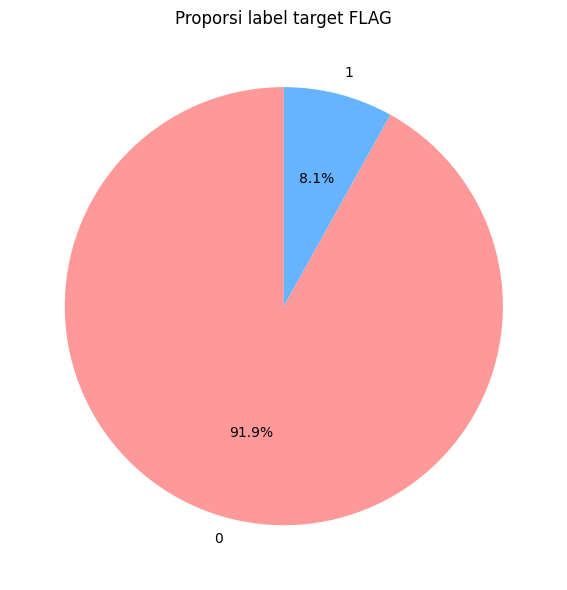

In [92]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
proportions_tr.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Proporsi label target FLAG')
plt.ylabel('')


plt.tight_layout()
plt.show()

Dari hasil di atas, dapat diketahui bahwa 91,9% data memiliki label target FLAG = 0, sedangkan sisanya memiliki label target FLAG = 1. Hal ini menunjukkan perbedaan proporsi yang sangat besar antara kedua kelompok label target.

#### **2.2 - Bagaimana pola jumlah pinjaman yang disetujui (`APPROVED_CREDIT`) dan karakteristiknya berdasarkan jenis kontrak (`CONTRACT_TYPE`)?**

In [93]:
# Menghitung statistik deskriptif dari APPROVED_CREDIT berdasarkan CONTRACT_TYPE
df_tr.groupby('CONTRACT_TYPE')['APPROVED_CREDIT'].describe()

,count,mean,std,min,25%,50%,75%,max
CONTRACT_TYPE,,,,,,,,
Cash loans,55699.0,626243.792097,404449.203601,45000.0,296280.0,540000.0,835380.0,4050000.0
Revolving loans,5804.0,323668.159890,238245.186683,135000.0,180000.0,270000.0,360000.0,2250000.0


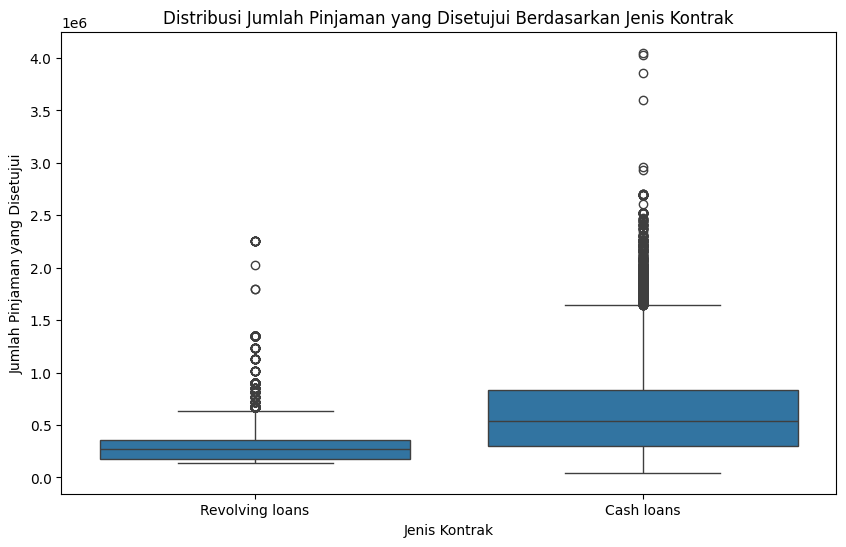

In [94]:
# Membuat boxplot untuk melihat distribusi APPROVED_CREDIT berdasarkan CONTRACT_TYPE
plt.figure(figsize=(10, 6))
sns.boxplot(x='CONTRACT_TYPE', y='APPROVED_CREDIT', data=df_tr)
plt.title('Distribusi Jumlah Pinjaman yang Disetujui Berdasarkan Jenis Kontrak')
plt.xlabel('Jenis Kontrak')
plt.ylabel('Jumlah Pinjaman yang Disetujui')
plt.show()

Dari hasil tersebut dapat diketahui bahwa jumlah pinjaman yang disetujui pada jenis kontrak Revolving Loans lebih kecil dibanding jumlah pinjaman yang disetujui dengan jenis kontrak Cash Loans. Jika dilihat dari distribusinya, terdapat banyak outlier pada jenis kontrak revolving loans ataupun cash loans.

#### **2.3 - Bagaimana korelasi antar fitur? Fitur apa yang berkorelasi kuat serta bagaimana tindakannya?**


Visualisasi heatmap hanya dapat digunakan untuk tipe data numerik saja. Oleh karena itu, akan dipilih data train yang memiliki tipe data numerik:

In [95]:
num = df_tr.select_dtypes(include=['int64', 'float64'])

In [96]:
num.corr()

,U_ID,FLAG,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_SINCE_ID_CHANGE,APPLY_HOUR,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3
U_ID,1.000000,0.003173,-0.004228,0.007124,0.000192,0.002940,0.000653,0.002354,0.000479,0.005554,0.003073,-0.002198,-0.005554,0.004900,0.004451
FLAG,0.003173,1.000000,0.018525,-0.020814,-0.039372,-0.019047,-0.047927,-0.083524,-0.051947,-0.039037,-0.055748,-0.029929,-0.175235,-0.159431,-0.182254
NUM_OF_CHILDREN,-0.004228,0.018525,1.000000,0.021530,0.007365,0.027297,0.003395,-0.331271,-0.241670,-0.178593,0.036734,-0.009091,-0.136222,-0.018246,-0.040431
INCOME,0.007124,-0.020814,0.021530,1.000000,0.279659,0.351515,0.285695,-0.050382,-0.116085,-0.053163,-0.017501,0.064925,0.062803,0.120227,-0.063953
APPROVED_CREDIT,0.000192,-0.039372,0.007365,0.279659,1.000000,0.771021,0.987017,0.049237,-0.069251,-0.014528,0.007247,0.052435,0.173309,0.132126,0.045288
LOAN_ANNUITY,0.002940,-0.019047,0.027297,0.351515,0.771021,1.000000,0.775949,-0.015771,-0.109904,-0.045753,-0.010125,0.052041,0.117709,0.126223,0.032916
PRODUCT_PRICE,0.000653,-0.047927,0.003395,0.285695,0.987017,0.775949,1.000000,0.048012,-0.066413,-0.016497,0.009235,0.062385,0.180624,0.140536,0.049573
DAYS_AGE,0.002354,-0.083524,-0.331271,-0.050382,0.049237,-0.015771,0.048012,1.000000,0.627082,0.324025,0.269007,-0.088924,0.601844,0.089171,0.204586
DAYS_WORK,0.000479,-0.051947,-0.241670,-0.116085,-0.069251,-0.109904,-0.066413,0.627082,1.000000,0.210428,0.274148,-0.088001,0.300982,-0.023302,0.119288
DAYS_REGISTRATION,0.005554,-0.039037,-0.178593,-0.053163,-0.014528,-0.045753,-0.016497,0.324025,0.210428,1.000000,0.099835,0.010861,0.175873,0.058790,0.104965


<Axes: >

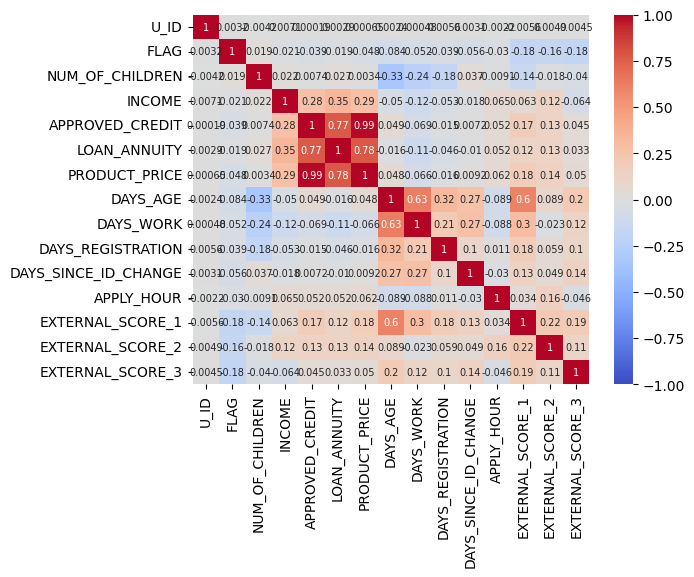

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(num.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7})


Terdapat korelasi yang kuat antara 3 fitur, yaitu Product Price, Loan Annuity dan Approved Credit. Dalam hal ini, pemodelan klasifikasi nantinya hanya akan menggunakan fitur **Product Price**. Karena Product Price menunjukkan harga barang atau layanan yang menjadi tujuan pemberian pinjaman sehingga secara langsung terkait dengan jumlah uang yang dipinjamkan kepada peminjam. Dalam proses pemberian pinjaman, lembaga keuangan biasanya mempertimbangkan jumlah uang yang diminta oleh peminjam, karena hal ini berdampak langsung pada risiko dan keuntungan dari pemberian pinjaman. 

Selain itu, data Product Price juga akan selalu tersedia karena  itu adalah informasi yang diberikan oleh peminjam saat mengajukan pinjaman. Namun, fitur Loan Annuity dan Approved Credit mungkin belum tersedia pada saat aplikasi diajukan. Loan Annuity adalah jumlah yang harus dibayarkan setiap bulan dan Approved Credit adalah jumlah kredit yang disetujui dari pinjaman. Kedua informasi ini mungkin belum diketahui pada tahap awal pengajuan pinjaman dan hanya akan tersedia setelah aplikasi diproses dan disetujui oleh lembaga keuangan.

Dengan mempertimbangkan kedua faktor di atas, fitur Product Price dapat menjadi pilihan yang lebih tepat untuk digunakan dalam pemodelan klasifikasi.

#### **2.4 - Bagaimana pola karakteristik jumlah pendapatan (INCOME) dengan kemungkinan diberikan pinjaman atau tidak (FLAG)?**

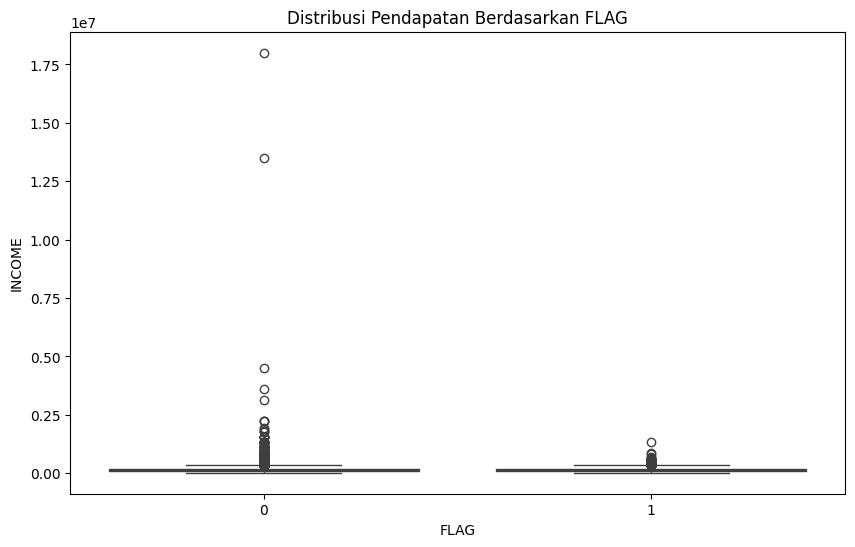

In [98]:
# Visualisasi distribusi pendapatan berdasarkan FLAG
plt.figure(figsize=(10, 6))
sns.boxplot(x='FLAG', y='INCOME', data=df_tr)
plt.title('Distribusi Pendapatan Berdasarkan FLAG')
plt.xlabel('FLAG')
plt.ylabel('INCOME')
plt.show()

In [99]:
# Statistik deskriptif untuk pendapatan berdasarkan FLAG
income_flag_0 = df_tr[df_tr['FLAG'] == 0]['INCOME']
income_flag_1 = df_tr[df_tr['FLAG'] == 1]['INCOME']

print("Statistik Deskriptif untuk Pendapatan (FLAG=0):")
print(income_flag_0.describe())
print("\nStatistik Deskriptif untuk Pendapatan (FLAG=1):")
print(income_flag_1.describe())

Statistik Deskriptif untuk Pendapatan (FLAG=0):
count    5.653400e+04
mean     1.699056e+05
std      1.376661e+05
min      2.610000e+04
25%      1.125000e+05
50%      1.485000e+05
75%      2.025000e+05
max      1.800009e+07
Name: INCOME, dtype: float64

Statistik Deskriptif untuk Pendapatan (FLAG=1):
count    4.969000e+03
mean     1.596733e+05
std      8.018258e+04
min      2.925000e+04
25%      1.125000e+05
50%      1.350000e+05
75%      2.025000e+05
max      1.350000e+06
Name: INCOME, dtype: float64


Jika dilihat dari output boxplot di atas, tidak terdapat perbedaan yang cukup signifikan antara INCOME dari peminjam yang disetujui (FLAG =1) ataupun tidak (FLAG = 0) karena adanya outlier yang cukup besar. Jika dilihat dari statistik deskriptif nya pun demikian. Akan tetapi, jika dilihat secara spesifik berdasarkan minimal INCOME antara kedua kelompok tersebut, minimal INCOME kelompok yang pinjamannya disetujui (FLAG = 1) lebih besar dibanding INCOME kelompok yang pinjamannya tidak disetujui (FLAG = 0).  

#### **2.5 - Bagaimana pola karakteristik antara INCOME_TYPE dengan FLAG?**

<Figure size 1000x600 with 0 Axes>

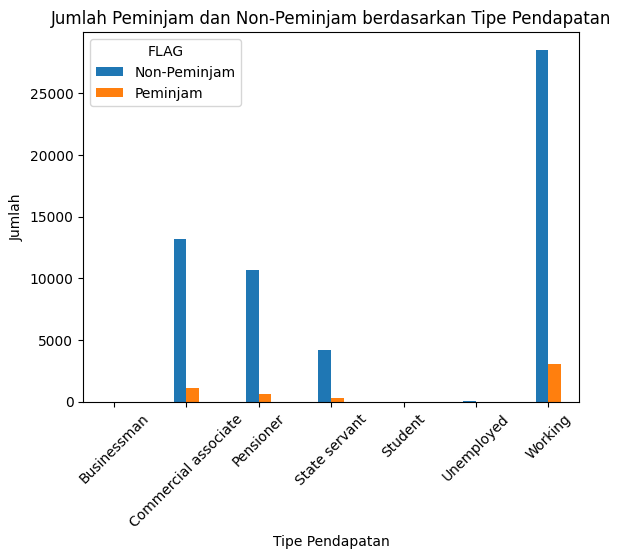

In [100]:
# Menghitung jumlah peminjam dan non-peminjam untuk setiap tipe pendapatan
income_flag_counts = df_tr.groupby(['INCOME_CATEGORY', 'FLAG']).size().unstack()

# Diagram batang grup
plt.figure(figsize=(10, 6))
income_flag_counts.plot(kind='bar', width=0.35)
plt.title('Jumlah Peminjam dan Non-Peminjam berdasarkan Tipe Pendapatan')
plt.xlabel('Tipe Pendapatan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Rotasi label sumbu x agar tidak tumpang tindih
plt.legend(title='FLAG', labels=['Non-Peminjam', 'Peminjam'])
plt.show()

In [101]:
df_tr[df_tr['FLAG']==1]['INCOME_CATEGORY'].groupby(df_tr['INCOME_CATEGORY']).count().sort_values(ascending = False)

INCOME_CATEGORY
Working                 3071
Commercial associate    1069
Pensioner                578
State servant            250
Unemployed                 1
Name: INCOME_CATEGORY, dtype: int64

In [102]:
df_tr[df_tr['FLAG']==0]['INCOME_CATEGORY'].groupby(df_tr['INCOME_CATEGORY']).count().sort_values(ascending = False)

INCOME_CATEGORY
Working                 28550
Commercial associate    13148
Pensioner               10671
State servant            4157
Unemployed                  4
Student                     3
Businessman                 1
Name: INCOME_CATEGORY, dtype: int64

Pada kelompok yang pinjamannya disetujui, diperoleh bahwa sebagaian besar INCOME_CATEGORY-nya adalah Working dan Commercial associate, dan untuk tipe INCOME_CATEGORY yang lainnya adalah Pensioner, State Servant, dan Unemployed.

Pada kelompok yang pinjamannya tidak disetujui, diperoleh bahwa sebagaian besar INCOME_CATEGORY-nya adalah Working dan Commercial associate, dan untuk tipe INCOME_CATEGORY yang lainnya adalah Pensioner, State Servant, Unemployed, Student, dan Businessman.

#### **2.6 - Pada hari apakah biasanya peminjam mengajukan pinjaman ?**

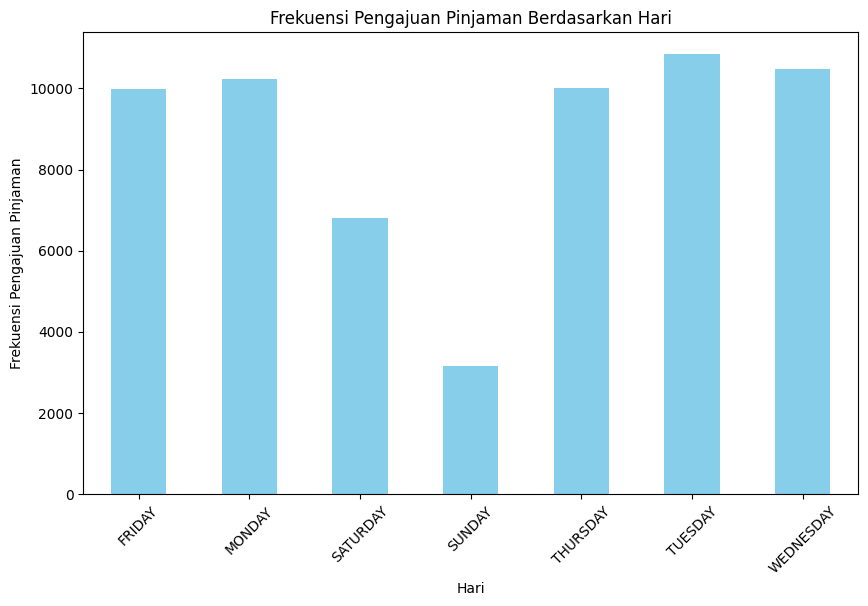

In [103]:
# Menghitung frekuensi pengajuan pinjaman pada setiap hari
loan_apply_days_counts = df_tr['APPLY_DAYS'].value_counts().sort_index()

# Membuat diagram batang
plt.figure(figsize=(10, 6))
loan_apply_days_counts.plot(kind='bar', color='skyblue')
plt.title('Frekuensi Pengajuan Pinjaman Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Frekuensi Pengajuan Pinjaman')
plt.xticks(rotation=45)
plt.show()

Dari hasil tersebut, dapat diketahui bahwa sebagian besar mengajukan pinjaman pada hari kerja.

#### **2.6 - Bagaimana pola karakteristik antara pendidikan peminjam dengan kemungkinan diberikan pinjaman?**

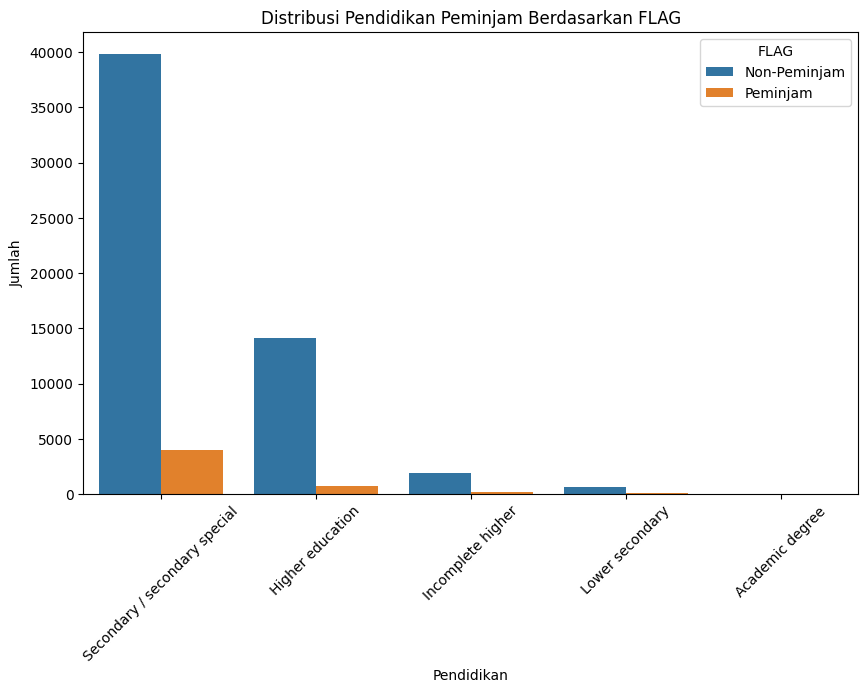

In [104]:
# Visualisasi distribusi pendidikan berdasarkan FLAG
plt.figure(figsize=(10, 6))
sns.countplot(x='EDUCATION', hue='FLAG', data=df_tr)
plt.title('Distribusi Pendidikan Peminjam Berdasarkan FLAG')
plt.xlabel('Pendidikan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.legend(title='FLAG', labels=['Non-Peminjam', 'Peminjam'])
plt.show()

Baik peminjam yang pinjamannya disetujui maupun tidak, sebagian besar pendidikannya adalah Secondary / secondary special.

<a name="3"></a>
# **3 - Preprocessing Data (2)**
Pada bagian ini dilakukan pra-pemrosesan data dan feature engineering melanjutkan proses data cleaning sebelumnya untuk digunakan dalam proses pemodelan berdasarkan insight yang diperoleh pada bagian EDA.

In [105]:
df_his.head()

,SK_ID_PREV,U_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375
1,2723183,112102,14,-197.0,-197.0,70.740,70.740
2,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080
3,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450
4,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000


In [106]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350712 entries, 0 to 350711
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 350712 non-null  int64  
 1   U_ID                       350712 non-null  int64  
 2   CONTRACT_TYPE              350712 non-null  object 
 3   LOAN_ANNUITY               274103 non-null  float64
 4   APPLICATION                350712 non-null  float64
 5   APPROVED_CREDIT            350712 non-null  float64
 6   AMT_DOWN_PAYMENT           164205 non-null  float64
 7   PRODUCT_PRICE              271072 non-null  float64
 8   APPLY_DAYS                 350712 non-null  object 
 9   APPLY_HOUR                 350712 non-null  int64  
 10  CONTRACT_STATUS            350712 non-null  object 
 11  DAYS_DECISION              350712 non-null  int64  
 12  TERM_PAYMENT               274103 non-null  float64
 13  YIELD_GROUP                35

Pertama, dibuat fitur baru PRE_LATE yang menunjukkan klien pernah telat atau tidak dalam melakukan pembayaran pinjaman sebelumnya, yaitu berdasarkan dataset payment_history. Nilainya berupa 1: Pernah telat bayar, 0: Tidak pernah telat bayar. Fitur ini diperoleh dari variabel INST_DAYS dan PAY_DAYS yang dijumlahkan berdasarkan U_ID. Jika  jumlah telat > 1, nilai dari PRE_LATE diubah nilainya menjadi 1, sedangkan kondisi lain nilai PRE_LATE diubah nilainya menjadi 0.

In [107]:
# Menghitung jumlah pembayaran telat untuk setiap peminjam
late_payment_count = df_his[df_his['INST_DAYS'] < df_his['PAY_DAYS']].groupby('U_ID').size()

# Membuat fitur PRE_LATE
df_tr['PRE_LATE'] = df_tr['U_ID'].map(late_payment_count)
df_te['PRE_LATE'] = df_te['U_ID'].map(late_payment_count)

# Mengubah nilai lebih dari 1 menjadi 1
df_tr['PRE_LATE'] = df_tr['PRE_LATE'].apply(lambda x: 1 if x > 1 else 0)
df_te['PRE_LATE'] = df_te['PRE_LATE'].apply(lambda x: 1 if x > 1 else 0)

# Imputasi nilai NA dengan 0
df_tr['PRE_LATE'].fillna(0, inplace=True)
df_te['PRE_LATE'].fillna(0, inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\1583892602.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tr['PRE_LATE'].fillna(0, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\1583892602.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Fitur kedua yang akan dibuat adalah PAY_HIS.  Fitur ini menunjukkan status kekurangan bayar klien sebelumnya, yang diperoleh dari AMT_INST - AMT_PAY, yang dijumlahkan berdasarkan U_ID. Nilainya berupa 1: Pernah kurang bayar dan 0: Tidak pernah kurang bayar. Jika nilainya negatif (klien kelebihan bayar) akan diubah menjadi 0. Ini dapat memberikan informasi tentang seberapa baik klien dalam membayar kreditnya.

In [108]:
# Menghitung selisih pembayaran
payment_difference = df_his['AMT_INST'] - df_his['AMT_PAY']

# Menggabungkan total selisih pembayaran berdasarkan U_ID
total_payment_difference = payment_difference.groupby(df_his['U_ID']).sum()

# Mengubah nilai negatif menjadi 0
total_payment_difference = total_payment_difference.apply(lambda x: max(0, x))

# Mengubah nilai menjadi biner (1 untuk pernah kurang bayar dan 0 untuk tidak pernah kurang bayar)
pay_history = (total_payment_difference > 0).astype(int)

# Menggabungkan nilai ke DataFrame train dan test
df_tr['PAY_HIS'] = df_tr['U_ID'].map(pay_history)
df_te['PAY_HIS'] = df_te['U_ID'].map(pay_history)

# Imputasi nilai NA dengan 0
df_tr['PAY_HIS'].fillna(0, inplace=True)
df_te['PAY_HIS'].fillna(0, inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\4070960787.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tr['PAY_HIS'].fillna(0, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\4070960787.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

Fitur ketiga yang akan dibuat adalah OVERREQUESTED_CREDIT. Fitur ini menunjukkan apakah klien meminta jumlah kredit yang lebih besar dari yang disetujui (APPROVED_CREDIT lebih kecil dari APPLICATION). Nilai 1: APPROVED_CREDIT lebih kecil dari APPLICATION dan 0: APPROVED_CREDIT lebih besar dari APPLICATION. Kemudian variabel ini akan dijumlahkan berdasarkan U_ID. Akhirnya, jika nilainya lebih dari atau sama dengan 1 akan diberi nilai 1, dan kondisi lainnya diberi nilai 0.

In [109]:
# Langkah 1: Hitung nilai OVERREQUESTED_CREDIT
df_pre['OVERREQUESTED_CREDIT'] = (df_pre['APPLICATION'] > df_pre['APPROVED_CREDIT']).astype(int)

# Langkah 2: Jumlahkan berdasarkan U_ID
overrequested_credit_sum = df_pre.groupby('U_ID')['OVERREQUESTED_CREDIT'].sum()

# Langkah 3: Ubah nilai-nilai yang lebih besar dari atau sama dengan 1 menjadi 1, dan nilai-nilai lainnya menjadi 0
overrequested_credit_sum = (overrequested_credit_sum >= 1).astype(int)

# Masukkan hasilnya ke dalam data train dan test
df_tr['OVERREQUESTED_CREDIT'] = df_tr['U_ID'].map(overrequested_credit_sum)
df_te['OVERREQUESTED_CREDIT'] = df_te['U_ID'].map(overrequested_credit_sum)

# Imputasi nilai NA dengan 0
df_tr['OVERREQUESTED_CREDIT'].fillna(0, inplace=True)
df_te['OVERREQUESTED_CREDIT'].fillna(0, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\2500553227.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tr['OVERREQUESTED_CREDIT'].fillna(0, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\2500553227.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Selanjutnya, akan dilakukan pre processing pada data test. Pertama kan dilihat struktur dari data test terlebih dahulu

In [110]:
df_te.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   14761 non-null  int64  
 1   FLAG                   14761 non-null  int64  
 2   CONTRACT_TYPE          14761 non-null  object 
 3   GENDER                 14761 non-null  object 
 4   NUM_OF_CHILDREN        14761 non-null  int64  
 5   INCOME                 14761 non-null  float64
 6   APPROVED_CREDIT        14761 non-null  float64
 7   LOAN_ANNUITY           14761 non-null  float64
 8   PRODUCT_PRICE          14741 non-null  float64
 9   INCOME_CATEGORY        14761 non-null  object 
 10  EDUCATION              14761 non-null  object 
 11  FAMILY_STATUS          14761 non-null  object 
 12  HOUSING_CATEGORY       14761 non-null  object 
 13  DAYS_AGE               14761 non-null  int64  
 14  DAYS_WORK              14761 non-null  int64  
 15  DA

In [111]:
df_te.isna().sum()

U_ID                        0
FLAG                        0
CONTRACT_TYPE               0
GENDER                      0
NUM_OF_CHILDREN             0
INCOME                      0
APPROVED_CREDIT             0
LOAN_ANNUITY                0
PRODUCT_PRICE              20
INCOME_CATEGORY             0
EDUCATION                   0
FAMILY_STATUS               0
HOUSING_CATEGORY            0
DAYS_AGE                    0
DAYS_WORK                   0
DAYS_REGISTRATION           0
DAYS_SINCE_ID_CHANGE        0
APPLY_DAYS                  0
APPLY_HOUR                  0
ORGANIZATION_CATEGORY    2727
EXTERNAL_SCORE_1         8312
EXTERNAL_SCORE_2           19
EXTERNAL_SCORE_3         2919
PRE_LATE                    0
PAY_HIS                     0
OVERREQUESTED_CREDIT        0
dtype: int64

Akan dilakukan penanganan mising value pada variabel kategorik dengan modus, dan variabel numerik dengan mean

In [112]:
df_te['ORGANIZATION_CATEGORY'].fillna(df_te['ORGANIZATION_CATEGORY'].mode()[0], inplace = True)
df_te['PRODUCT_PRICE'].fillna(df_te['PRODUCT_PRICE'].mean(), inplace = True)
df_te['EXTERNAL_SCORE_1'].fillna(df_te['EXTERNAL_SCORE_1'].mean(), inplace = True)
df_te['EXTERNAL_SCORE_2'].fillna(df_te['EXTERNAL_SCORE_2'].mean(), inplace = True)
df_te['EXTERNAL_SCORE_3'].fillna(df_te['EXTERNAL_SCORE_3'].mean(), inplace = True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\795690423.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_te['ORGANIZATION_CATEGORY'].fillna(df_te['ORGANIZATION_CATEGORY'].mode()[0], inplace = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21740\795690423.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [113]:
df_te.isna().sum()

U_ID                     0
FLAG                     0
CONTRACT_TYPE            0
GENDER                   0
NUM_OF_CHILDREN          0
INCOME                   0
APPROVED_CREDIT          0
LOAN_ANNUITY             0
PRODUCT_PRICE            0
INCOME_CATEGORY          0
EDUCATION                0
FAMILY_STATUS            0
HOUSING_CATEGORY         0
DAYS_AGE                 0
DAYS_WORK                0
DAYS_REGISTRATION        0
DAYS_SINCE_ID_CHANGE     0
APPLY_DAYS               0
APPLY_HOUR               0
ORGANIZATION_CATEGORY    0
EXTERNAL_SCORE_1         0
EXTERNAL_SCORE_2         0
EXTERNAL_SCORE_3         0
PRE_LATE                 0
PAY_HIS                  0
OVERREQUESTED_CREDIT     0
dtype: int64

Sudah tidak terdapat missing value pada data. Selanjutnya, akan dilakukan label encoder pada data kategorik

In [114]:
#Label Encoder pada data kategorik
labelEncoder1 = LabelEncoder()
label_cols = ['CONTRACT_TYPE', 'GENDER', 'INCOME_CATEGORY', 'FAMILY_STATUS',
       'HOUSING_CATEGORY', 'APPLY_DAYS', 'ORGANIZATION_CATEGORY']

for i in label_cols:
    df_te[i] = labelEncoder1.fit_transform(df_te[i])

df_te['EDUCATION'] = labelEncoder1.fit_transform(df_te['EDUCATION'])

In [115]:
#Dilihat data hasil preprocessing
df_te.head()

,U_ID,FLAG,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,...,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,PRE_LATE,PAY_HIS,OVERREQUESTED_CREDIT
0,219092,0,0,1,3,135000.0,871029.0,44604.0,765000.0,4,...,1131,2,7,5,0.507092,0.145475,0.651260,0,1.0,1.0
1,141577,0,0,0,0,144000.0,485640.0,34537.5,450000.0,4,...,4872,1,14,28,0.507092,0.682675,0.511901,1,1.0,0.0
2,180205,0,0,0,1,90000.0,247500.0,8887.5,247500.0,4,...,1930,2,12,42,0.814700,0.686312,0.758393,0,0.0,0.0
3,357381,0,0,1,2,112500.0,506889.0,24781.5,418500.0,4,...,4048,4,13,33,0.399219,0.266520,0.058826,1,1.0,0.0
4,271229,0,0,1,0,216000.0,450000.0,21888.0,450000.0,4,...,2035,1,14,5,0.368452,0.610483,0.392774,0,0.0,1.0


<a name="4"></a>
# **4 - Modelling**
**Hanya menggunakan dataset train.csv**
### Splitting Data
Dilakukan splitting data train menjadi `train` dan `val` dengan proporsi `60:40`.

In [287]:
from sklearn.model_selection import train_test_split

X = df_tr.drop(columns='FLAG')
y = df_tr['FLAG']

Selanjutnya, dilakukan splitting data

In [288]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [289]:
X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)
y_val.reset_index(drop=True, inplace = True)

<a name="ex4.1"></a>
### **Preprocessing Data (3) - Pipeline**
Tahap preprocessing data dilakukan dengan operator `pipeline` pada scikit-learn agar lebih mudah digunakan dan menghindari kemungkinan terjadinya kebocoran (leakage) data tes saat pemodelan.

Akan dilihat terlebih dahulu missing value dan struktur dari data

In [119]:
X_train.isna().sum()

U_ID                         0
CONTRACT_TYPE                0
GENDER                       0
NUM_OF_CHILDREN              0
INCOME                       0
APPROVED_CREDIT              0
LOAN_ANNUITY                 1
PRODUCT_PRICE               41
INCOME_CATEGORY              0
EDUCATION                    0
FAMILY_STATUS                0
HOUSING_CATEGORY             0
DAYS_AGE                     0
DAYS_WORK                    0
DAYS_REGISTRATION            0
DAYS_SINCE_ID_CHANGE         0
APPLY_DAYS                   0
APPLY_HOUR                   0
ORGANIZATION_CATEGORY        0
EXTERNAL_SCORE_1         20948
EXTERNAL_SCORE_2            85
EXTERNAL_SCORE_3          7368
PRE_LATE                     0
PAY_HIS                      0
OVERREQUESTED_CREDIT         0
dtype: int64

In [120]:
X_val.isna().sum()

U_ID                         0
CONTRACT_TYPE                0
GENDER                       0
NUM_OF_CHILDREN              0
INCOME                       0
APPROVED_CREDIT              0
LOAN_ANNUITY                 0
PRODUCT_PRICE               21
INCOME_CATEGORY              0
EDUCATION                    0
FAMILY_STATUS                0
HOUSING_CATEGORY             0
DAYS_AGE                     0
DAYS_WORK                    0
DAYS_REGISTRATION            0
DAYS_SINCE_ID_CHANGE         0
APPLY_DAYS                   0
APPLY_HOUR                   0
ORGANIZATION_CATEGORY        0
EXTERNAL_SCORE_1         13897
EXTERNAL_SCORE_2            49
EXTERNAL_SCORE_3          4871
PRE_LATE                     0
PAY_HIS                      0
OVERREQUESTED_CREDIT         0
dtype: int64

In [121]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36901 entries, 0 to 36900
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   36901 non-null  int64  
 1   CONTRACT_TYPE          36901 non-null  object 
 2   GENDER                 36901 non-null  object 
 3   NUM_OF_CHILDREN        36901 non-null  int64  
 4   INCOME                 36901 non-null  float64
 5   APPROVED_CREDIT        36901 non-null  float64
 6   LOAN_ANNUITY           36900 non-null  float64
 7   PRODUCT_PRICE          36860 non-null  float64
 8   INCOME_CATEGORY        36901 non-null  object 
 9   EDUCATION              36901 non-null  object 
 10  FAMILY_STATUS          36901 non-null  object 
 11  HOUSING_CATEGORY       36901 non-null  object 
 12  DAYS_AGE               36901 non-null  int64  
 13  DAYS_WORK              36901 non-null  int64  
 14  DAYS_REGISTRATION      36901 non-null  float64
 15  DA

In [122]:
X

,U_ID,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,...,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,PRE_LATE,PAY_HIS,OVERREQUESTED_CREDIT
0,333538,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,Working,Secondary / secondary special,...,2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN,0,0.0,1.0
1,406644,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,Commercial associate,Secondary / secondary special,...,2455,TUESDAY,14,Other,0.655600,0.684298,NaN,1,0.0,0.0
2,259130,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,Pensioner,Secondary / secondary special,...,4312,THURSDAY,14,Business Entity Type 3,NaN,0.580687,0.749022,0,0.0,0.0
3,411997,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,State servant,Higher education,...,4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674,1,1.0,1.0
4,241559,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,Commercial associate,Secondary / secondary special,...,1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,251159,Cash loans,M,2,360000.0,450000.0,44509.5,450000.0,State servant,Secondary / secondary special,...,2709,FRIDAY,6,Electricity,0.295858,0.104877,0.616122,0,0.0,0.0
61499,441376,Cash loans,F,0,441000.0,904500.0,38452.5,904500.0,Pensioner,Secondary / secondary special,...,4191,TUESDAY,12,Business Entity Type 3,0.693816,0.411595,0.239226,1,1.0,0.0
61500,184648,Revolving loans,F,0,202500.0,900000.0,45000.0,900000.0,Commercial associate,Higher education,...,1263,FRIDAY,16,Industry: type 12,0.802154,0.714627,NaN,0,0.0,0.0
61501,313981,Cash loans,F,0,94500.0,360000.0,17509.5,360000.0,Working,Secondary / secondary special,...,3698,FRIDAY,15,Business Entity Type 3,NaN,0.694125,0.105473,1,1.0,1.0


In [123]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24602 entries, 0 to 24601
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   U_ID                   24602 non-null  int64  
 1   CONTRACT_TYPE          24602 non-null  object 
 2   GENDER                 24602 non-null  object 
 3   NUM_OF_CHILDREN        24602 non-null  int64  
 4   INCOME                 24602 non-null  float64
 5   APPROVED_CREDIT        24602 non-null  float64
 6   LOAN_ANNUITY           24602 non-null  float64
 7   PRODUCT_PRICE          24581 non-null  float64
 8   INCOME_CATEGORY        24602 non-null  object 
 9   EDUCATION              24602 non-null  object 
 10  FAMILY_STATUS          24602 non-null  object 
 11  HOUSING_CATEGORY       24602 non-null  object 
 12  DAYS_AGE               24602 non-null  int64  
 13  DAYS_WORK              24602 non-null  int64  
 14  DAYS_REGISTRATION      24602 non-null  float64
 15  DA

Selanjutnya akan dilakukan Pre-Processing dengan pipeline meliputi penanganan missing value, data scaling, dan encoding data ordinal.

In [290]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", MinMaxScaler())
])

categorical_ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("ordinal", OrdinalEncoder())
])

In [291]:
numerik = ['NUM_OF_CHILDREN', 'INCOME', 'APPROVED_CREDIT', 'LOAN_ANNUITY',
       'PRODUCT_PRICE', 'DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION',
       'DAYS_SINCE_ID_CHANGE', 'APPLY_HOUR', 'EXTERNAL_SCORE_1',
       'EXTERNAL_SCORE_2', 'EXTERNAL_SCORE_3', 'PRE_LATE', 'PAY_HIS',
       'OVERREQUESTED_CREDIT']
ordinal = ['EDUCATION']

In [292]:
preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numerik),
    ("ordinal", categorical_ordinal_pipeline, ordinal)
])

In [293]:
preprocessor.fit(X_train, X_val)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['NUM_OF_CHILDREN', 'INCOME',
                                  'APPROVED_CREDIT', 'LOAN_ANNUITY',
                                  'PRODUCT_PRICE', 'DAYS_AGE', 'DAYS_WORK',
                                  'DAYS_REGISTRATION', 'DAYS_SINCE_ID_CHANGE',
                                  'APPLY_HOUR', 'EXTERNAL_SCORE_1',
                                  'EXTERNAL_SCORE_2', 'EXTERNAL_SCORE_3',
                                  'PRE_LATE', 'PAY_HIS',
                                  'OVERREQUESTED_CREDIT']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['EDUCATION'])])

In [294]:
#Menerapkan preprocessing pada data train
X_train_proses = preprocessor.fit_transform(X_train)

#Menerapkan preprocessing yang telah dihitung ke data validation
X_val_proses = preprocessor.transform(X_val)

In [295]:
X_train_proses_df = pd.DataFrame(X_train_proses, columns = numerik+ordinal)
X_val_proses_df = pd.DataFrame(X_val_proses, columns = numerik+ordinal)

In [296]:
list_col = X_train_proses_df.columns
for i in list_col:
    X_train[i] = X_train_proses_df[i]
    X_val[i] = X_val_proses_df[i]

In [297]:
X_train.select_dtypes(include = 'object').columns

Index(['CONTRACT_TYPE', 'GENDER', 'INCOME_CATEGORY', 'FAMILY_STATUS',
       'HOUSING_CATEGORY', 'APPLY_DAYS', 'ORGANIZATION_CATEGORY'],
      dtype='object')

In [298]:
#Label Encoder pada data nominal
labelEncoder = LabelEncoder()
label_cols = ['CONTRACT_TYPE', 'GENDER', 'INCOME_CATEGORY', 'FAMILY_STATUS',
       'HOUSING_CATEGORY', 'APPLY_DAYS', 'ORGANIZATION_CATEGORY']

for i in label_cols:
    X_train[i] = labelEncoder.fit_transform(X_train[i])
    X_val[i] = labelEncoder.fit_transform(X_val[i])

In [133]:
X_train.isna().sum()

U_ID                     0
CONTRACT_TYPE            0
GENDER                   0
NUM_OF_CHILDREN          0
INCOME                   0
APPROVED_CREDIT          0
LOAN_ANNUITY             0
PRODUCT_PRICE            0
INCOME_CATEGORY          0
EDUCATION                0
FAMILY_STATUS            0
HOUSING_CATEGORY         0
DAYS_AGE                 0
DAYS_WORK                0
DAYS_REGISTRATION        0
DAYS_SINCE_ID_CHANGE     0
APPLY_DAYS               0
APPLY_HOUR               0
ORGANIZATION_CATEGORY    0
EXTERNAL_SCORE_1         0
EXTERNAL_SCORE_2         0
EXTERNAL_SCORE_3         0
PRE_LATE                 0
PAY_HIS                  0
OVERREQUESTED_CREDIT     0
dtype: int64

In [134]:
X_val.isna().sum()

U_ID                     0
CONTRACT_TYPE            0
GENDER                   0
NUM_OF_CHILDREN          0
INCOME                   0
APPROVED_CREDIT          0
LOAN_ANNUITY             0
PRODUCT_PRICE            0
INCOME_CATEGORY          0
EDUCATION                0
FAMILY_STATUS            0
HOUSING_CATEGORY         0
DAYS_AGE                 0
DAYS_WORK                0
DAYS_REGISTRATION        0
DAYS_SINCE_ID_CHANGE     0
APPLY_DAYS               0
APPLY_HOUR               0
ORGANIZATION_CATEGORY    0
EXTERNAL_SCORE_1         0
EXTERNAL_SCORE_2         0
EXTERNAL_SCORE_3         0
PRE_LATE                 0
PAY_HIS                  0
OVERREQUESTED_CREDIT     0
dtype: int64

Sudah tidak terdapat missing value pada data

Dilihat data hasil pre processing

In [116]:
X_train.head()

,U_ID,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,...,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,PRE_LATE,PAY_HIS,OVERREQUESTED_CREDIT
0,398015,0,1,0.0,0.032193,0.101124,0.077045,0.101124,5,1.0,...,0.325363,5,0.478261,42,0.084788,0.375891,0.170119,1.0,1.0,1.0
1,199310,1,1,0.0,0.019115,0.073034,0.056930,0.073034,5,4.0,...,0.624582,4,0.478261,42,0.519640,0.175397,0.391039,0.0,0.0,0.0
2,113926,0,0,0.0,0.005030,0.024270,0.031747,0.016854,2,4.0,...,0.503268,0,0.826087,30,0.519640,0.623597,0.482907,1.0,1.0,1.0
3,153829,0,0,0.0,0.019115,0.020562,0.019252,0.016854,1,4.0,...,0.671290,3,0.478261,5,0.519640,0.825744,0.818874,0.0,0.0,1.0
4,436374,0,0,0.0,0.014085,0.200000,0.108651,0.200000,5,4.0,...,0.154950,6,0.565217,5,0.649524,0.825357,0.569805,0.0,0.0,1.0


In [117]:
X_val.head()

,U_ID,CONTRACT_TYPE,GENDER,NUM_OF_CHILDREN,INCOME,APPROVED_CREDIT,LOAN_ANNUITY,PRODUCT_PRICE,INCOME_CATEGORY,EDUCATION,...,DAYS_SINCE_ID_CHANGE,APPLY_DAYS,APPLY_HOUR,ORGANIZATION_CATEGORY,EXTERNAL_SCORE_1,EXTERNAL_SCORE_2,EXTERNAL_SCORE_3,PRE_LATE,PAY_HIS,OVERREQUESTED_CREDIT
0,186368,0,0,0.0,0.020121,0.012719,0.035460,0.011236,6,4.0,...,0.227005,5,0.478261,5,0.150712,0.558606,0.579096,0.0,0.0,1.0
1,339923,0,0,0.0,0.064386,0.239169,0.136791,0.219101,1,4.0,...,0.673203,4,0.565217,5,0.519640,0.908578,0.275453,0.0,0.0,0.0
2,440280,0,1,0.0,0.064386,0.141726,0.102457,0.112360,6,4.0,...,0.474414,2,0.434783,3,0.519640,0.561012,0.625090,1.0,1.0,0.0
3,456067,0,1,0.0,0.029175,0.262840,0.116958,0.228090,2,4.0,...,0.622509,1,0.478261,5,0.519640,0.587080,0.829756,0.0,0.0,0.0
4,128212,0,0,0.0,0.024145,0.122015,0.083380,0.107865,6,4.0,...,0.431532,4,0.739130,55,0.829806,0.662490,0.870611,0.0,0.0,1.0


Berdasarkan eksplorasi data sebelumnya diketahui bahwa proporsi label target `FLAG` tidak seimbang. Oleh karena itu, dilakukan SMOTE untuk menyeimbangkan data train

In [299]:
#menyeimbangkan data train dengan smote
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Tujuan utama dari implementasi prediksi pada PDM PayLater adalah untuk mengurangi kerugian finansial akibat gagal bayar. Oleh karena itu, sangat penting untuk menghindari prediksi False Positive, yaitu kasus di mana seseorang diprediksi sebagai peminjam yang baik (layak diberi pinjaman), padahal kenyataannya merupakan peminjam yang buruk (berisiko gagal bayar).

Maka, metrik evaluasi utama yang paling tepat digunakan adalah `precision`. Precision mengukur proporsi peminjam yang benar-benar baik di antara semua peminjam yang diprediksi baik oleh model. Dengan kata lain, precision memastikan bahwa mayoritas peminjam yang diberi pinjaman berdasarkan prediksi model memiliki risiko gagal bayar yang rendah, sehingga mengurangi potensi kerugian finansial.

In [138]:
# Tentukan metric yang akan digunakan
list_of_metric = [
    'f1',
    'precision',
]

# Tuliskan semua model yang ingin digunakan beserta parameter di dalamnya

list_of_model = [
    LogisticRegression(max_iter = 1000),
    LogisticRegressionCV(max_iter = 10000),
    GradientBoostingClassifier(random_state = 0),
    HistGradientBoostingClassifier(random_state = 0),
    CatBoostClassifier(random_state = 0),
    XGBClassifier(random_state = 0),
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(), DecisionTreeClassifier(), AdaBoostClassifier(), RandomForestClassifier(), QuadraticDiscriminantAnalysis()
]

In [139]:
# Membuat fungsi untuk mengevaluasi semua model secara otomatis

def all_model(list_model, X_train, X_test, y_train, y_test):

    # List kosong untuk menyimpan semua hasil pengukuran
    result = []
    for model in list_model:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Menghitung nilai berdasarkan model yang sudah di train / fit dan hasil prediksinya
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Mengumpulkan nilai-nilai di atas menjadi satu
        hasil = {
            'Model' : type(model).__name__,
            'F1 Score' : f1,
            'Precision' : precision,
        }

        # Simpan nilai model dalam list result
        result.append(hasil)

    # Ubah menjadi dataframe
    result_all = pd.DataFrame(result)

    return result_all


In [140]:
all_listed_model = all_model(list_of_model, X_train, X_val, y_train, y_val)
all_listed_model

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.06237
0:	learn: 0.6227533	total: 217ms	remaining: 3m 37s
1:	learn: 0.5628145	total: 507ms	remaining: 4m 12s
2:	learn: 0.5105806	total: 600ms	remaining: 3m 19s
3:	learn: 0.4924106	total: 1.09s	remaining: 4m 32s
4:	learn: 0.4582886	total: 1.93s	remaining: 6m 24s
5:	learn: 0.4214476	total: 2.06s	remaining: 5m 41s
6:	learn: 0.4004766	total: 2.12s	remaining: 5m 1s
7:	learn: 0.3905874	total: 2.17s	remaining: 4m 29s
8:	learn: 0.3729606	total: 2.22s	remaining: 4m 4s
9:	learn: 0.3509674	total: 2.26s	remaining: 3m 44s
10:	learn: 0.3396220	total: 2.33s	remaining: 3m 29s
11:	learn: 0.3232239	total: 2.37s	remaining: 3m 15s
12:	learn: 0.3161123	total: 2.43s	remaining: 3m 4s
13:	learn: 0.3112403	total: 2.48s	remaining: 2m 54s
14:	learn: 0.3021613	total: 2.53s	remaining: 2m 45s
15:	learn: 0.2959768	total: 2.57s	remaining: 2m 38s
16:	learn: 0.2921069	total: 2.62s	remaining: 2m 31s
17:	learn: 0.2766934	total: 2.68s	remaining: 2m 26s
18:	learn: 0.2733234	total: 2.73s	remaining: 2m 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,F1 Score,Precision
0,LogisticRegression,0.223939,0.139867
1,LogisticRegressionCV,0.230248,0.146411
2,GradientBoostingClassifier,0.107590,0.201102
3,HistGradientBoostingClassifier,0.098862,0.224599
4,CatBoostClassifier,0.119290,0.239032
5,XGBClassifier,0.132316,0.238532
6,BernoulliNB,0.150980,0.093648
7,GaussianNB,0.149562,0.081911
8,KNeighborsClassifier,0.126931,0.076793
9,SVC,0.119989,0.082098


In [195]:
# Mengurutkan berdasarkan nilai precision
all_listed_model.sort_values(by=['Precision', 'F1 Score'], ascending=[False, False])

,Model,F1 Score,Precision
12,RandomForestClassifier,0.066463,0.254181
4,CatBoostClassifier,0.119290,0.239032
5,XGBClassifier,0.132316,0.238532
3,HistGradientBoostingClassifier,0.098862,0.224599
2,GradientBoostingClassifier,0.107590,0.201102
11,AdaBoostClassifier,0.145176,0.175589
1,LogisticRegressionCV,0.230248,0.146411
0,LogisticRegression,0.223939,0.139867
10,DecisionTreeClassifier,0.167063,0.137942
13,QuadraticDiscriminantAnalysis,0.193060,0.115665


Diperoleh algoritma terbaik untuk klasifikasi adalah Random Forest Classifier.

In [201]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'class_weight': ['balanced']}
scoring = {'precision': 'precision', 'f1': 'f1'}

# GridSearchCV
grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid=params,
    scoring=scoring,
    refit='precision', 
    cv=5
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 10],
                         'n_estimators': [100, 200]},
             refit='precision', scoring={'f1': 'f1', 'precision': 'precision'})

In [202]:
grid.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

<a name="ex4.3"></a>
### Model Terbaik

Selanjutnya, akan dibuat model terbaik dari algoritma terbaik yang telah diperoleh.

In [ ]:
best = RandomForestClassifier(random_state = 540, class_weight='balanced', max_depth=10, n_estimators=100 )
best.fit(X_train, y_train) # fitting model terbaik menggunakan data latih

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=540)

<a name="5"></a>
## 5 - Evaluation
Lakukanlah uji performa model terbaik di atas dengan memprediksi data test.csv menggunakan **setidaknya 3 metrik evaluasi yang berbeda** dan berikan interpretasi.


In [360]:
X_test = df_te.drop(columns = 'FLAG')
y_test = df_te['FLAG']

# Predict the test set
Y_pred = best.predict(X_test)

# Check the classification report
print(precision_score(y_test, Y_pred), f1_score(y_test, Y_pred))

0.3 0.00494641384995878


Setelah dilakukan serangkaian pre processing data dan pemodelan, diperoleh bahwa model terbaik adalah klasifikasi dengan algoritma Random Forest Classifier. Model ini mampu memprediksi model baru dengan metrik precision sebesar 0,3.

<a name="6"></a>
# **6 - Post Analysis**


<a name="ex6.1"></a>
### Feature Importance

In [213]:
from sklearn.inspection import permutation_importance

Didefinisikan fungsi untuk melakukan visualisasi fitur importance

In [322]:
def plot_fi(model, X = X_val, y = y_val, rep = 10):
    perm = permutation_importance(model, X, y, n_repeats=10, random_state=0, n_jobs=-1)

    perm2 = pd.DataFrame({'feature': X.columns.tolist()*rep, 'importance': perm["importances"].transpose().reshape(-1)})
    perm2["importance"] = perm2.importance/perm2.importance.sum()*rep
    urut = perm2.groupby("feature").mean().sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    fig, axs = plt.subplots(1, 2, figsize=(25, 15))

    sns.barplot(x='importance', y='feature', data=perm2, order=urut.index, ax=axs[0])
    sns.stripplot(x='importance', y='feature', data=perm2, order = urut.index, s=5, ax=axs[1])
    plt.show()

    return urut

Ditampilkan fiture importance

<Figure size 800x600 with 0 Axes>

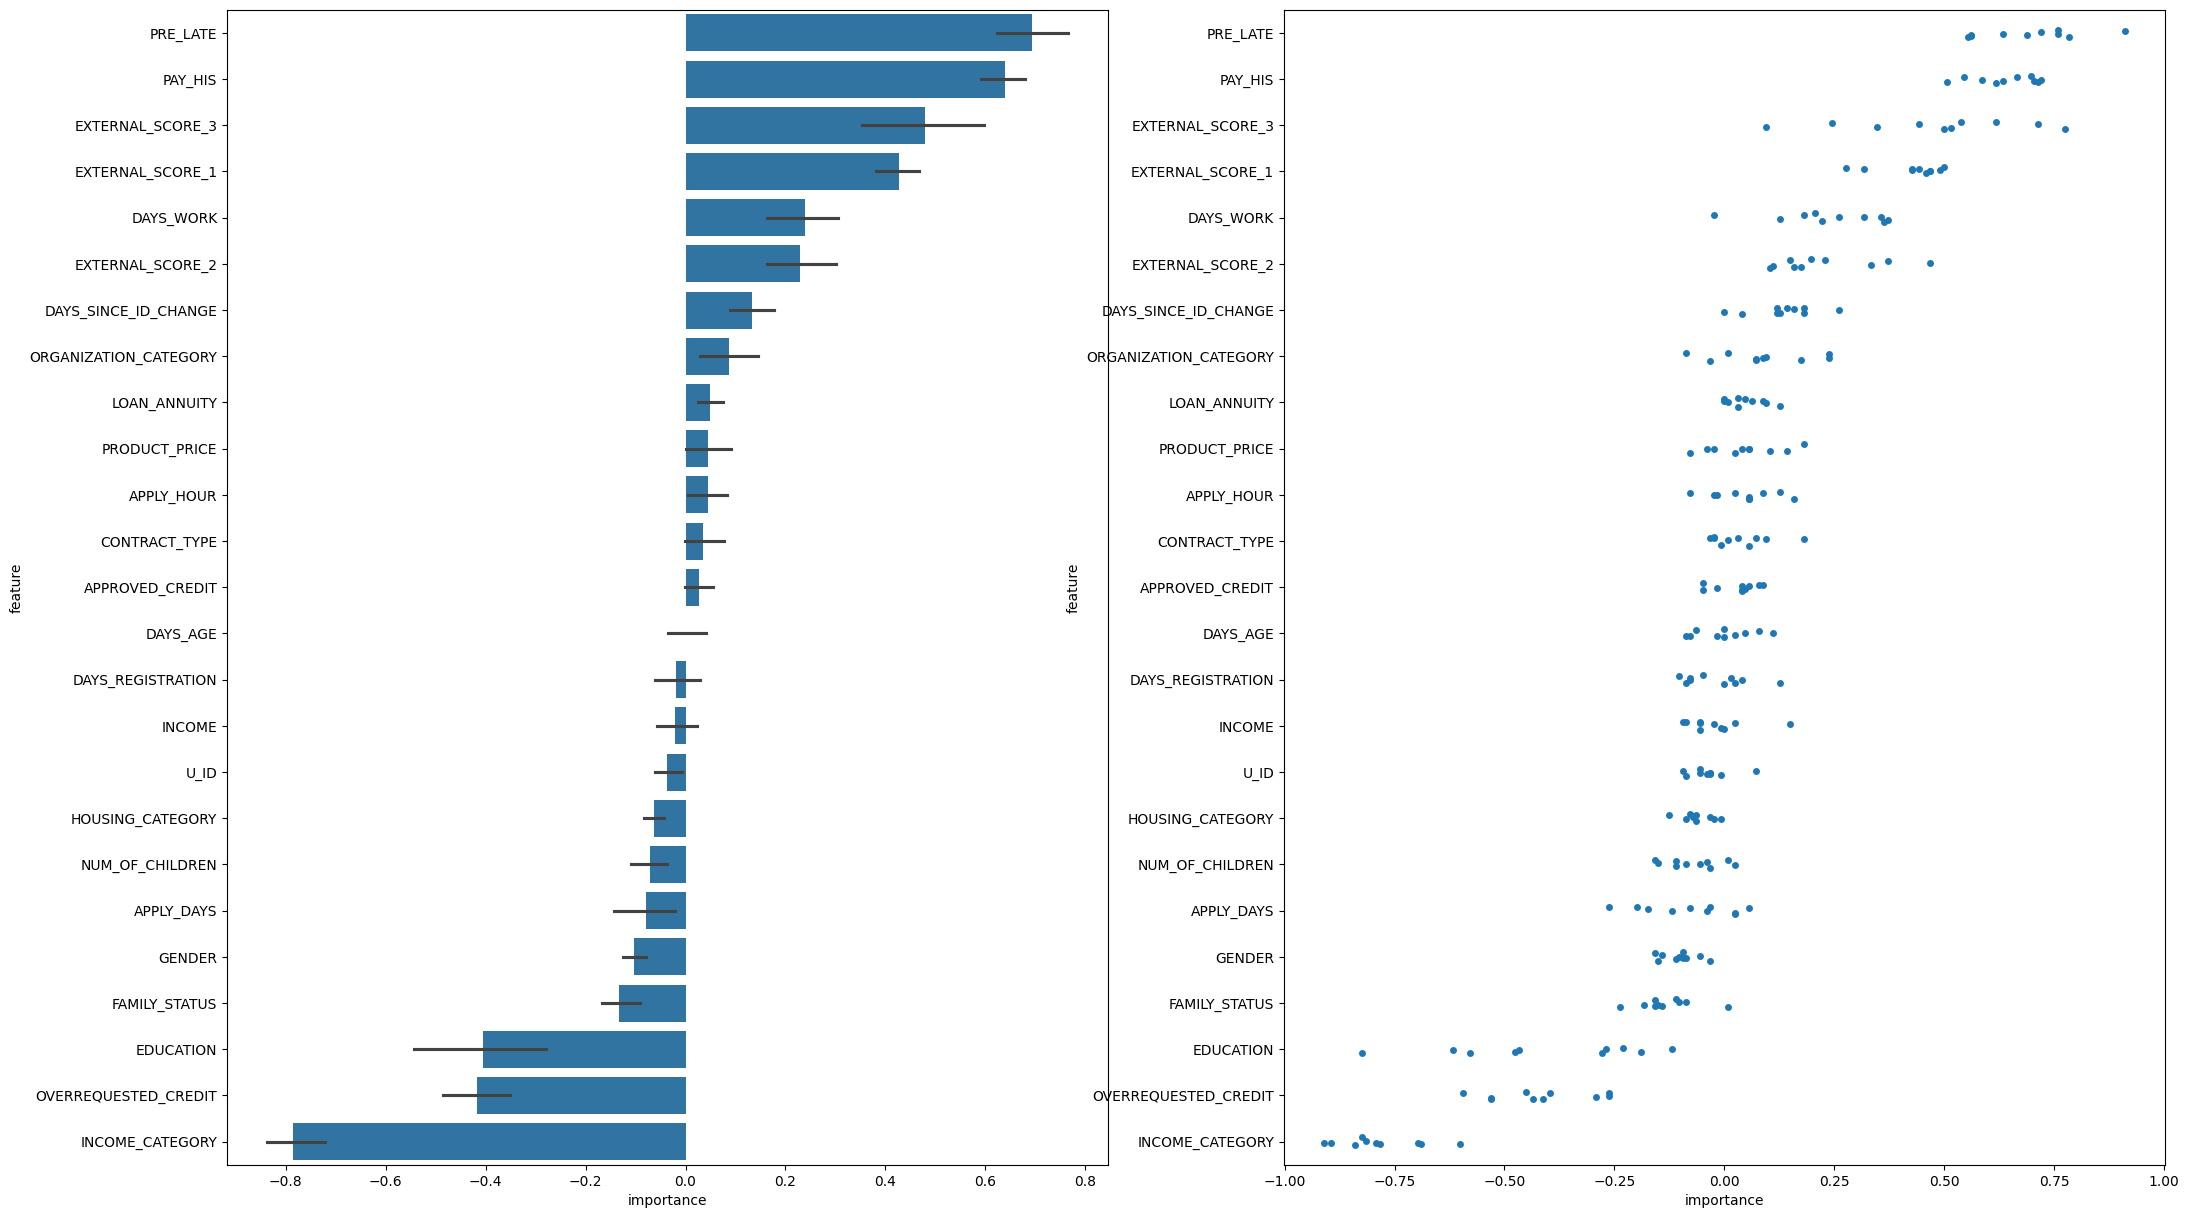

,importance
feature,
PRE_LATE,0.693587
PAY_HIS,0.638955
EXTERNAL_SCORE_3,0.479018
EXTERNAL_SCORE_1,0.427553
DAYS_WORK,0.238321
EXTERNAL_SCORE_2,0.229612
DAYS_SINCE_ID_CHANGE,0.133017
ORGANIZATION_CATEGORY,0.086302
LOAN_ANNUITY,0.049089


In [361]:
plot_fi(model = best, X = X_val, y = y_val)

Berikut adalah interpretasi dari fitur importance yang diberikan:

1. **PRE_LATE**: Diperoleh nilai importances sebesar 0.693587, dimana fitur ini memiliki nilai importance tertinggi di antara semua fitur. PRE_LATE adalah fitur yang paling berpengaruh terhadap prediksi model. Model sangat bergantung pada fitur ini untuk membuat keputusan. Dalam konteks kredit atau pinjaman, PRE_LATE kemungkinan besar menunjukkan keterlambatan pembayaran sebelumnya, yang merupakan indikator penting untuk memprediksi risiko kredit.

2. **PAY_HIS**: Diperoleh nilai importances sebesar 0.638955, dimana fitur ini memiliki nilai importance kedua tertinggi.PAY_HIS (history pembayaran) juga sangat berpengaruh terhadap prediksi model. Ini menunjukkan bahwa riwayat pembayaran adalah faktor penting dalam menentukan risiko atau hasil yang diprediksi oleh model. Jika pelanggan memiliki riwayat pembayaran yang buruk, kemungkinan besar akan mempengaruhi keputusan model secara signifikan.

3. **EXTERNAL_SCORE_3**: Diperoleh nilai importances sebesar 0.479018. EXTERNAL_SCORE_3 menunjukkan pengaruh moderat terhadap prediksi model. Meskipun penting, pengaruhnya lebih rendah dibandingkan dengan fitur-fitur yang lebih tinggi dalam daftar. 

4. **EXTERNAL_SCORE_1**: Diperoleh nilai importances sebesar 0.427553. EXTERNAL_SCORE_1 juga menunjukkan pengaruh moderat terhadap prediksi model.

5. **DAYS_WORK**: Diperoleh nilai importances sebesar 0.238321. DAYS_WORK adalah fitur penting tetapi tidak sekuat PRE_LATE atau PAY_HIS. Ini merujuk pada jumlah hari antara tanggal seseorang mulai bekerja di pekerjaan saat ini dan tanggal mereka mengajukan pinjaman.

<a name="7"></a>
# **7 - Conclusion & Recommendation**


**KESIMPULAN:**

Dari serangkaian proses analisis klasifikasi komprehensif yang telah dilakukan sebelumnya, diperoleh bawa algoritma terbaik untuk memprediksi klien yang pantas untuk diberi pinjaman dan tidak (FLAG) adalah Random Forest Classifier dengan precision sebesar 0,3. Dengan fitur yang paling berpengaruh dalam prediksi model adalah `PRE_LATE`, `PAY_HIS`, `EXTERNAL_SCORE_1`, `EXTERNAL_SCORE_3`, dan `DAYS_WORK`.

**REKOMENDASI:**

Berdasarkan kesimpulan yang diperoleh, perusahaan disarankan untuk memberikan pinjaman kepada peminjam yang memenuhi kriteria berikut:
1. Tidak pernah terlambat melakukan pembayaran
2. Tidak memiliki riwayat pembayaran yang buruk atau gagal bayar
3. Memiliki durasi kerja yang cukup lama di pekerjaan saat ini sebelum mengajukan pinjaman. Peminjam dengan pekerjaan yang stabil cenderung memiliki risiko gagal bayar lebih rendah.